In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from typing import List
import os
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, utils
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import models

#### Useful links:

Transfer learning example:
- https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/


#### TODO: 
- Sigmoid or Softmax

- Which loss funciton

- Data Augmentation

## Utils

Add util functions below when needed

In [52]:
class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='binary'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 5))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)
            ax.set_ylabel('Percentage')
            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


def plot_test_images_with_labels(X_test, y_test, predictions=[], probabilities=[], num_images=10, index=0, only_wrong = False, probability = False):
    """
    Plots test images with their true and predicted labels.
    
    Parameters:
    - X_test: Array of test images.
    - y_test: Array of true labels for the test images.
    - predictions: Array of predicted labels for the test images.
    - num_images: Number of images to plot. Default is 10.
    """
    # Ensure num_images doesn't exceed the number of test images
    num_images = min(num_images, len(X_test))
    
    # Create a figure with a grid of subplots
    plt.figure(figsize=(20, 10))
    i = -1
    plotted = 0
    if probability == False:
        while plotted < num_images:
            i+=1
            if (only_wrong == True) and (y_test[i+index]==predictions[i+index]):
                continue
            # Get the image, true label, and predicted label
            img = X_test[i+index]
            true_label = 'War related' if y_test[i+index] == 1 else 'Non war related'
            predicted_label = 'War related' if predictions[i+index] == 1 else 'Non war related'
            # Add subplot
            plt.subplot(2, (num_images + 1) // 2, plotted + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')
            plotted +=1
        if only_wrong == True:
            print(f'Last plotted image index: {i+index}')
        index = index+i+1
    else:   
        while plotted < num_images:
            i+=1
            if (only_wrong == True) and (y_test[i+index]==predictions[i+index]):
                continue
            # Get the image, true label, and predicted label
            img = X_test[i+index]
            true_label = 'War related' if y_test[i+index] == 1 else 'Non war related'
            predicted_label = float(probabilities[i+index])
            # Add subplot
            plt.subplot(2, (num_images + 1) // 2, plotted + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nProb: {predicted_label}")
            plt.axis('off')
            plotted +=1
        if only_wrong == True:
            print(f'Last plotted image index: {i+index+1}')
        index = index+i+1

    plt.tight_layout()
    plt.show()
    return index
    
    
# Function to visualise class imbalance over batchers
def visualise_dataloader(dl):
    total_num_images = len(dl.dataset)
    class_0_batch_counts = []
    class_1_batch_counts = []

    graph_df = pd.DataFrame({
        'batch_num':[],
        'class_0':[],
        'class_1':[]
    })

    for i, batch in enumerate(dl):
        
        labels = batch[1].tolist()
        unique_labels = set(labels)
        if len(unique_labels) > 2:
            raise ValueError("More than two classes detected")
        
        class_0_count = labels.count(0)
        class_1_count = labels.count(1)

        class_0_batch_counts.append(class_0_count)
        class_1_batch_counts.append(class_1_count)
        
        graph_df.loc[len(graph_df)] = [i+1, class_0_count, class_1_count]
    
    plt.figure(figsize=(10, 6))

    # Bar width
    bar_width = 0.35

    # Plotting bars for class_1
    plt.bar(graph_df['batch_num'], graph_df['class_1'], bar_width, label='Class 1')

    # Plotting bars for class_0
    plt.bar(graph_df['batch_num'] + bar_width, graph_df['class_0'], bar_width, label='Class 0')

    # Adding labels and title
    plt.xlabel('Batch Number')
    plt.ylabel('Number of Images')
    plt.title('Number of Class 1 and Class 0 for Each Batch Number')
    plt.legend()

    plt.tight_layout()
    plt.show()        

# Convert images back to standard size
def denormalize(image_numpy, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image_numpy = (image_numpy * std + mean)
    return image_numpy

def reverse_transform(image_numpy):
    # Define mean and std used for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Denormalize
    image_numpy = denormalize(image_numpy, mean, std)
    
    # Clip the values to be in the range [0, 1]
    image_numpy = np.clip(image_numpy, 0, 1)
    
    # Convert to PIL image
    #'image_pil = Image.fromarray((image_numpy * 255).astype(np.uint8))
    
    return image_numpy

def evaluate_model_with_images(model, dataloader, threshold=0.5, activation='sigmoid', device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_images = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            if activation == 'softmax':
                # Softmax
                probs = F.softmax(outputs, dim=1)  # Get probabilities for each class
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities of the positive class
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(inputs.cpu().numpy())
            elif activation == 'sigmoid':
                # Sigmodid
                probs = torch.sigmoid(outputs)  # Use sigmoid for binary classification
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(inputs.cpu().numpy())
    
    # Reverse transformations for all images
    denormalized_images = [reverse_transform(image.transpose(1, 2, 0)) for image in all_images]
    
    return denormalized_images, all_labels, all_probs

def evaluate_model(model, dataloader, activation='sigmoid', device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_probs = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            if activation == 'sigmoid':
                probs = torch.sigmoid(outputs)  # Use sigmoid for binary classification
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            elif activation == 'softmax':
                probs = F.softmax(outputs, dim=1)  # Get probabilities for each class
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities of the positive class
                all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_probs

# Find the optimal threshold for F1 score
def find_best_threshold(y_true, probs):
    best_f1 = 0
    best_threshold = 0

    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        predictions = [1 if prob >= threshold else 0 for prob in probs]
        f1 = f1_score(y_true, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

def occlusion_sensitivity(model, image, label, patch_size=50, baseline=0):
    """
    Perform occlusion sensitivity analysis on a given image.
    
    Parameters:
    - model: Trained model.
    - image: Input image.
    - label: True label of the input image.
    - patch_size: Size of the patch to occlude.
    - baseline: Baseline value for occlusion (default is 0).
    
    Returns:
    - heatmap: Occlusion sensitivity heatmap.
    """
    _, _, img_height, img_width = image.shape
    heatmap = np.zeros((img_height, img_width))
    
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            occluded_image = image.copy()
            occluded_image[i:i+patch_size, j:j+patch_size, :] = baseline
            
            # Predict the output for the occluded image
            occluded_image = np.expand_dims(occluded_image, axis=0)
            preds = model.predict(occluded_image)
            class_score = preds[0, label]  # Score for the true class
            
            # Record the change in the heatmap
            heatmap[i:i+patch_size, j:j+patch_size] = class_score
    
    return heatmap

def occlusion_sensitivity_mask(model, image, patch_size=50):
    """
    Perform occlusion sensitivity analysis with mask sliding over a given image.
    
    Parameters:
    - model: Trained model.
    - image: Preprocessed input image tensor (1, C, H, W).
    - patch_size: Size of the patch to keep.
    
    Returns:
    - heatmap: Occlusion sensitivity heatmap.
    """
    model.eval()  # Set the model to evaluation mode
    _, _, img_height, img_width = image.shape
    heatmap = np.zeros((img_height, img_width))
    
    # Move the image tensor to the correct device
    device = next(model.parameters()).device
    image = image.to(device)
    
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            # Create a masked image
            occluded_image = torch.zeros_like(image)  # Mask initialized with zeros (full occlusion)
            i_end = min(i + patch_size, img_height)
            j_end = min(j + patch_size, img_width)
            occluded_image[:, :, i:i_end, j:j_end] = image[:, :, i:i_end, j:j_end]
            
            # Predict the output for the occluded patch
            with torch.no_grad():
                output = model(occluded_image)
                score = torch.sigmoid(output).item()
            
            # Record the score in the heatmap
            heatmap[i:i_end, j:j_end] = score
            # print(score)
    
    return heatmap



In [3]:
# Load labels
# df = pd.read_csv("data/new_labels.csv")
df = pd.read_csv("data/final_labels.csv")
df['choice'].value_counts()

choice
not_war                          7843
low_confidence_war                983
military                          746
damaged_infrastructure            364
military&anchor                   268
damaged_infrastructure&anchor     135
Name: count, dtype: int64

In [4]:
df.head(5)

,channel,image,label,choice,choice_no_lc,label_no_lc
0,atres,frame_atres_noche_2024-05-17_sec_1310.jpg,not_war,not_war,not_war,not_war
1,atres,frame_atres_noche_2024-05-17_sec_1290.jpg,not_war,not_war,not_war,not_war
2,atres,frame_atres_noche_2024-05-17_sec_1270.jpg,not_war,not_war,not_war,not_war
3,atres,frame_atres_noche_2024-05-17_sec_1250.jpg,not_war,not_war,not_war,not_war
4,atres,frame_atres_noche_2024-05-17_sec_1230.jpg,not_war,not_war,not_war,not_war


In [5]:
# Print total number of images
print(f'Total number of labelled images: {len(df)}')

Total number of labelled images: 10339


In [6]:
# # Convert to war not war and visualise class imbalance
# df = df[df['choice'] != 'low_confidence_war']

# label_mapping = {
#     'not_war': 'not_war',
#     'military': 'war',
#     'damaged_infrastructure': 'war',
#     'military&anchor': 'war',
#     'damaged_infrastructure&anchor': 'war'
# }

# df['choice'] = df['choice'].map(label_mapping)

# class_counts = df['choice'].value_counts()
# class_counts

### Create DataSet class

In [7]:
df['choice'].value_counts()

choice
not_war                          7843
low_confidence_war                983
military                          746
damaged_infrastructure            364
military&anchor                   268
damaged_infrastructure&anchor     135
Name: count, dtype: int64

In [8]:
class WarDataset(Dataset):

    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(labels_file)
        self.transform = transform
        
        # # Remove low_confidence_war from data
        # self.img_labels = self.img_labels[self.img_labels['choice'] != 'low_confidence_war']
        self.img_labels = self.img_labels[['image','label_no_lc']]


    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        # Convert tensor to PIL image
        image = to_pil_image(image)
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
            
        # Adjust label according to our current schema
        label_mapping = {
            'not_war': 0,
            'military': 1,
            'damaged_infrastructure': 1,
            'military&anchor': 1,
            'damaged_infrastructure&anchor': 1,
            'war':1
        }
        
        if label in label_mapping:
            label = label_mapping[label]

        return image, label

    def __len__(self):
        return len(self.img_labels)


### Create DataLoader

Transforming functions

In [9]:
# Define transform to reshape image to 256x256 and normalise to ImageNet standards
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std = [0.229, 0.224, 0.225]
        )
    ])

In [10]:
# Initialize the dataset
# img_dir = 'data/labelled_images'
img_dir = 'data/all_frames'
# labels_file = 'data/new_labels.csv'
labels_file = 'data/final_labels.csv'
dataset = WarDataset(img_dir, labels_file, transform=transform)

# Define the sizes for training, validation, and testing sets
train_size = int(0.7 * len(dataset)) 
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  

# Split dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Extract train labels from dataset object and calculate sample weights
train_label_list = []
for i in train_dataset:
    label = i[1]
    train_label_list.append(label)
    
train_labels = pd.DataFrame({'labels': train_label_list})
class_counts = train_labels['labels'].value_counts()
sample_weights = [1/class_counts[i] for i in train_labels['labels'].values]

Creating Data Loader

In [11]:
# Create sampler for the train to fix class imbalance - note sample weights calculated above
sampler = WeightedRandomSampler(weights=sample_weights, num_samples = len(train_dataset), replacement=True)

# Create a DataLoader
train_loader = DataLoader(train_dataset, sampler = sampler, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

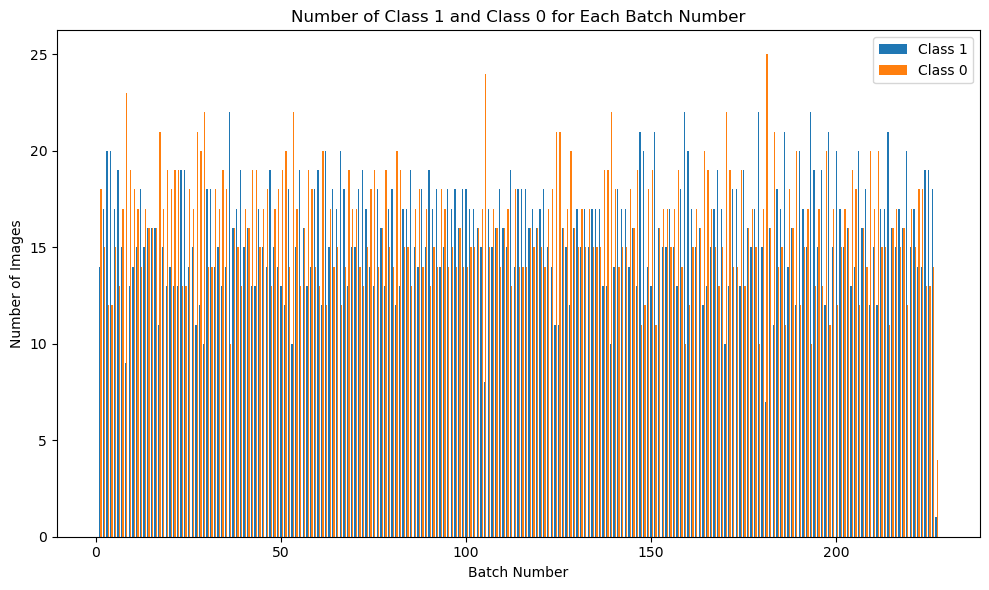

In [14]:
# # Observe label distribution for train_loader and test_loader
# visualise_dataloader(train_loader)

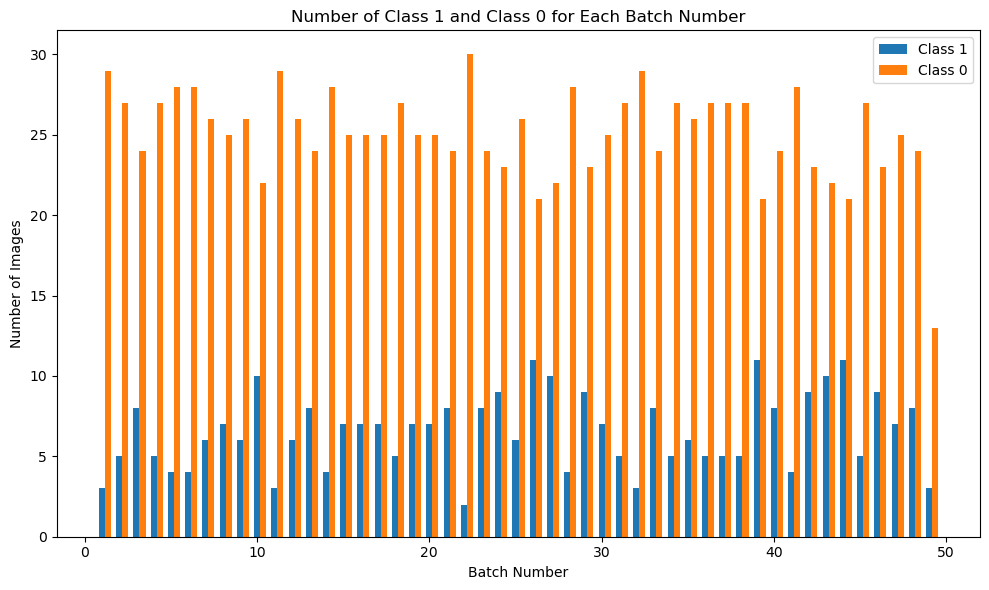

In [16]:
# visualise_dataloader(test_loader)

Display image from a batch from the dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


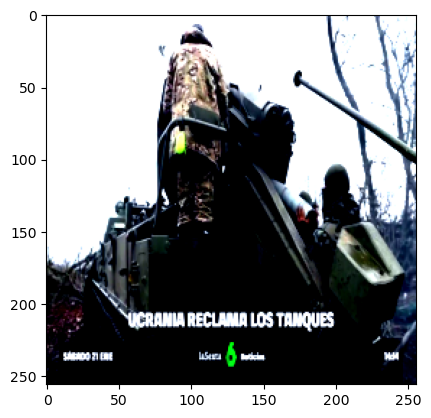

Label:     1


In [15]:
# train_features, train_labels = next(iter(train_loader))
# print(f"Feature batch shape: {train_features.size()}")
# img = train_features[0].permute(1, 2, 0).numpy()  # Permute to (height, width, channels) and convert to numpy
# label = train_labels[0]

# print(label)
# plt.figure(figsize=(5, 10))
# plt.imshow(img)
# plt.show

# Fucntion to visualize data from DataLoader
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select only the first 5 images and labels
images = images[:1]
labels = labels[:1]

# Show images
imshow(utils.make_grid(images))
current_label = ' '.join('%5s' % labels[j].item() for j in range(len(labels)))
# Print labels
print("Label:", current_label)

# Model Training

In [18]:
# dir(models)

### Output layer activaiton functions

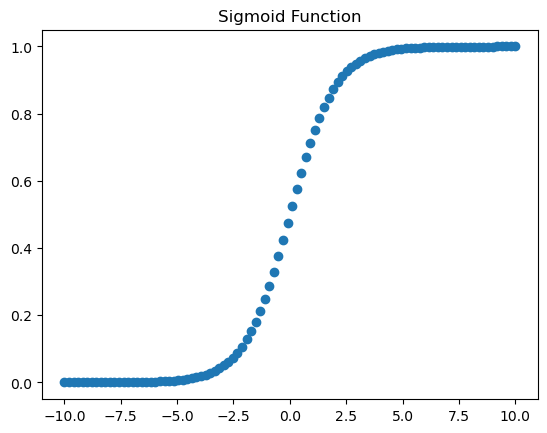

0.7310585786300049


In [35]:
# def sigmoid(x): 
#  return 1/(1+np.exp(-x))

# x = np.linspace(-10, 10, 100) 
# y = sigmoid(x)
# plt.scatter(x, y) 
# plt.title('Sigmoid Function') 
# plt.show()

# x = 1
# output = sigmoid(x)
# print(output)

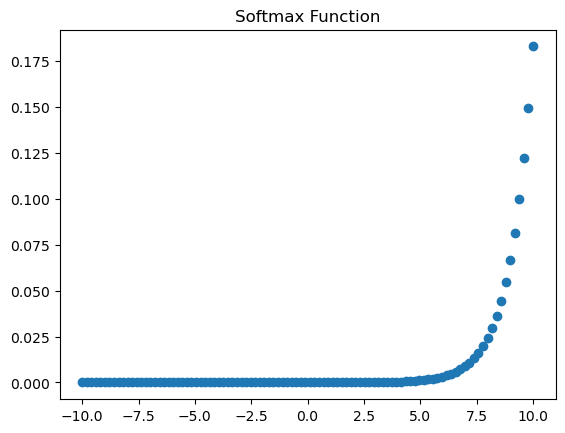

[4.53922671e-05 1.23388975e-04 9.99831219e-01]


In [46]:
# def softmax(x): 
#  return np.exp(x)/np.sum(np.exp(x))

# x = np.linspace(-10, 10, 100)
# y = softmax(x)
# plt.scatter(x, y) 
# plt.title('Softmax Function') 
# plt.show()

# x = [5, 6, 15]
# output = softmax(x)
# print(output)

THe sigmoid function is more adequate for binary classificaiton as it is less computationally expensive avoiding redundant computations and is more numerically stable. We will use it for our model selecting the BCEWithLogitsLoss() ove the CrossEntropyLoss(), as it takes as input raw logits and applies the sigmoid internally. Number of output classes should be set to 1 as the sigmoid will output a single probability.

In [ ]:
# Move the model to the GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

## ResNet 50 - Transfer Learning

#### Explanation:

- Pretrained ResNet50 Model with Imagenet Weights.
- Adding a small custom head and training it with ResNet parameters frozen.
- Transfer Learning: unfreezing some parameters of the pretrained model and training again but with a lower learning rate.

Load the data using a dataloader

In [12]:
# Create sampler for the train to fix class imbalance - note sample weights calculated above
sampler = WeightedRandomSampler(weights=sample_weights, num_samples = len(train_dataset), replacement=True)

# Create a DataLoader
train_loader = DataLoader(train_dataset, sampler = sampler, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Defining the model

In [13]:
resnet50 = torchvision.models.resnet50(weights=("pretrained", models.ResNet50_Weights.IMAGENET1K_V1))

# Freeze all the parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = resnet50.fc.in_features
# Define the custom head with two additional dense layers
resnet50.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 512),
    torch.nn.ReLU(),
    # torch.nn.Dropout(0.5),  # Optional dropout for regularization
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    # torch.nn.Dropout(0.5),  # Optional dropout for regularization
    torch.nn.Linear(256, 1)
)

# Move the model to the GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

print(resnet50)

/Users/user/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
os.getcwd()

'/Users/user/Desktop/Thesis---War-Image-Classification'

In [18]:
# Load the weights
saved_weights_path = './models/TL-L4/resnet50_TL-L4.pth' # Change it to the path where the weights are stored
resnet50.load_state_dict(torch.load(saved_weights_path, map_location=device))

# Verify that the weights are loaded correctly
print(resnet50)
trained_model=resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the training loop

In [ ]:
# Define a function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            if not os.path.isdir('./model_weights'):
                os.makedirs('model_weights')
            torch.save(model.state_dict(), 'model_weights/ResNet_best_model_training.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping')
                model.load_state_dict(torch.load('model_weights/ResNet_best_model_training.pth'))
                return model

    print('\nTraining complete!')
    model.load_state_dict(torch.load('model_weights/ResNet_best_model_training.pth'))
    return model

Training the model to initialize the custome head's weights based on the ResNet parameters

In [15]:
# Train the model
trained_model = train_model(resnet50, train_loader, val_loader, criterion, optimizer, num_epochs=15, patience=3)

Epoch 1/15: 100%|██████████| 114/114 [03:08<00:00,  1.66s/batch, loss=0.234]


Epoch [1/15], Loss: 0.3867
Validation Loss: 0.3343


Epoch 2/15: 100%|██████████| 114/114 [03:10<00:00,  1.67s/batch, loss=0.283]


Epoch [2/15], Loss: 0.3103
Validation Loss: 0.2694


Epoch 3/15: 100%|██████████| 114/114 [03:10<00:00,  1.67s/batch, loss=0.29] 


Epoch [3/15], Loss: 0.2849
Validation Loss: 0.2228


Epoch 4/15: 100%|██████████| 114/114 [03:07<00:00,  1.65s/batch, loss=0.201]


Epoch [4/15], Loss: 0.2659
Validation Loss: 0.2981


Epoch 5/15: 100%|██████████| 114/114 [03:03<00:00,  1.61s/batch, loss=0.409]


Epoch [5/15], Loss: 0.2865
Validation Loss: 0.2155


Epoch 6/15: 100%|██████████| 114/114 [03:03<00:00,  1.61s/batch, loss=0.106]


Epoch [6/15], Loss: 0.2584
Validation Loss: 0.2708


Epoch 7/15: 100%|██████████| 114/114 [02:33<00:00,  1.35s/batch, loss=0.158]


Epoch [7/15], Loss: 0.2518
Validation Loss: 0.3744


Epoch 8/15: 100%|██████████| 114/114 [02:34<00:00,  1.36s/batch, loss=0.434]


Epoch [8/15], Loss: 0.2461
Validation Loss: 0.2292
Early stopping


Unfreezing 1 layer in the pretrained model and lowering the learning rate

In [16]:
# Step 3: Fine-tune the model
for param in resnet50.parameters():
    param.requires_grad = False
for param in resnet50.layer4.parameters():
    param.requires_grad = True

optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)  # Lower learning rate for fine-tuning

Training and conducting the transfer learning based on our dataset to the pretrained model

In [17]:
trained_model=train_model(resnet50, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)

Epoch 1/10: 100%|██████████| 114/114 [02:54<00:00,  1.53s/batch, loss=0.0621]


Epoch [1/10], Loss: 0.1816
Validation Loss: 0.2181


Epoch 2/10: 100%|██████████| 114/114 [02:56<00:00,  1.55s/batch, loss=0.0105]


Epoch [2/10], Loss: 0.0782
Validation Loss: 0.2483


Epoch 3/10: 100%|██████████| 114/114 [02:57<00:00,  1.55s/batch, loss=0.00145]


Epoch [3/10], Loss: 0.0429
Validation Loss: 0.2732


Epoch 4/10: 100%|██████████| 114/114 [02:50<00:00,  1.50s/batch, loss=0.000499]


Epoch [4/10], Loss: 0.0340
Validation Loss: 0.3006
Early stopping


Testing for out of sample predictions and finding the optimal threshold to maximise F1.

*** This is wrong. We should use the validation data to find the optimal threshold. this will decrease the F1.

In [19]:
test_images, test_labels, test_probs = evaluate_model_with_images(trained_model, test_loader, device=device)

# Calculate the best threshold
best_threshold, best_f1 = find_best_threshold(test_labels, test_probs)
print(f"Best Threshold: {best_threshold}")
# Generate final predictions based on optimal threshold
test_preds = [1 if prob >= best_threshold else 0 for prob in test_probs]

Evaluating: 100%|██████████| 25/25 [00:37<00:00,  1.50s/batch]


Best Threshold: 0.6


Plotting the computed metrics

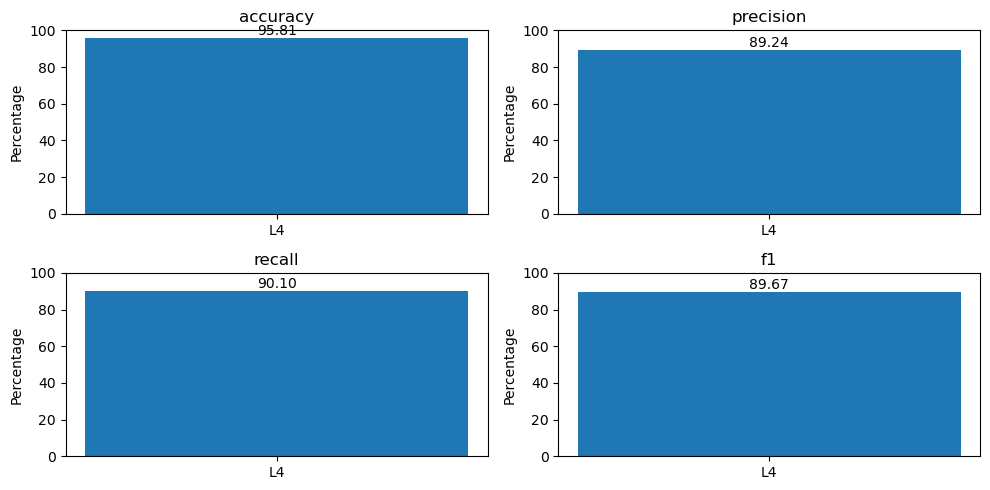

In [20]:
metrics = Metrics()
metrics.run(test_labels, test_preds, "L4")
metrics.plot()

Saving the model

In [23]:
if not os.path.isdir('./models/TL-L4'):
    os.makedirs('./models/TL-L4')
# Save ResNet50 model weights
torch.save(resnet50.state_dict(), 'models/TL-L4/resnet50_TL-L4.pth')

Plotting the images with their prediction

In [40]:
index=0

Last plotted image index: 344


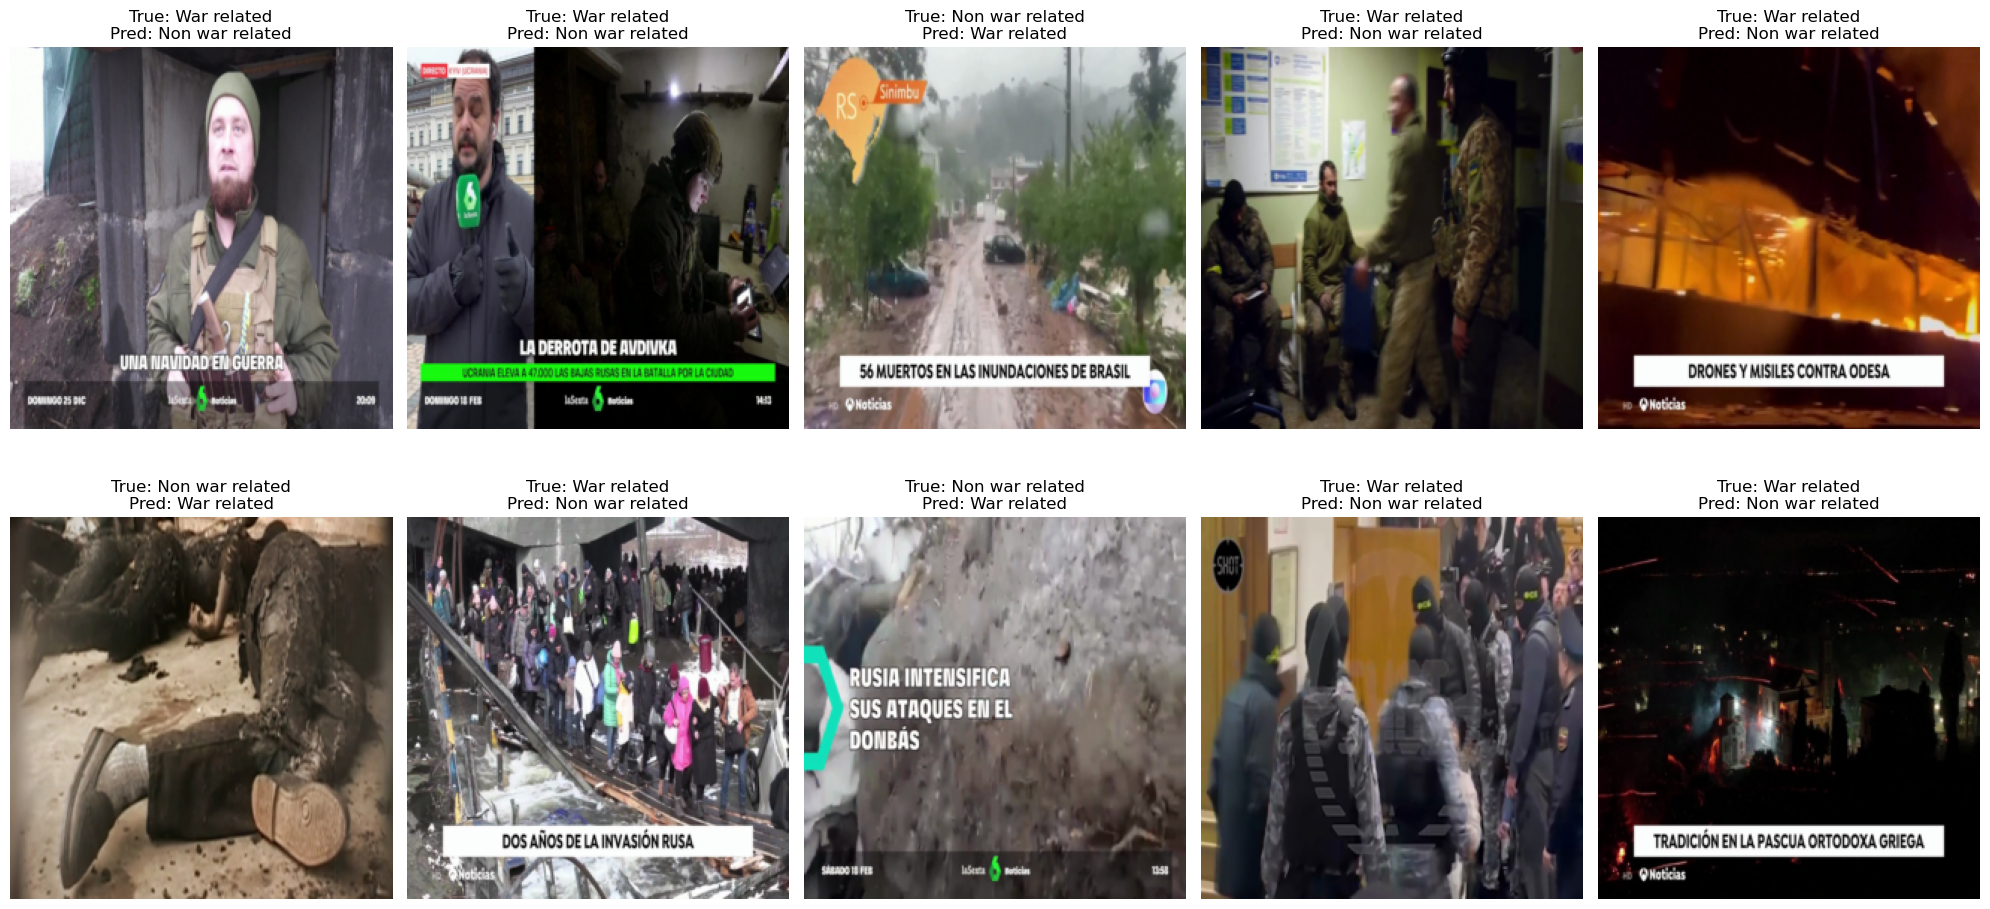

In [42]:
index = plot_test_images_with_labels(test_images, test_labels, test_preds, num_images=10, index=index, only_wrong=True)

## Feature Importance

In [79]:
def occlusion_sensitivity_mask(model, image, image_array, label, patch_size=50):
    """
    Perform occlusion sensitivity analysis with mask sliding over a given image.
    
    Parameters:
    - model: Trained model.
    - image: Input image.
    - label: True label of the input image.
    - patch_size: Size of the patch to occlude.
    
    Returns:
    - heatmap: Occlusion sensitivity heatmap.
    """
    
    img_height, img_width= 256,256
    heatmap = np.zeros((img_height, img_width))
    # Define transform to reshape image to 256x256 and normalise to ImageNet standards
    transform = transforms.Compose([
        transforms.Resize((256, 256))
        ])
    
    for i in range(0, img_height - patch_size + 1, patch_size):
        for j in range(0, img_width - patch_size + 1, patch_size):
            occluded_image = np.ones_like(image_array)  # Mask initialized with ones (no occlusion)
            occluded_image[i:i+patch_size, j:j+patch_size, :] = image_array[i:i+patch_size, j:j+patch_size, :]
            
            # Predict the output for the occluded patch
            # occluded_image = np.expand_dims(occluded_image, axis=0)
            transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std = [0.229, 0.224, 0.225]
                )])
            # Apply the transformations to the image
            image_tensor = transform(occluded_image).unsqueeze(0)  # Add batch dimension
            # Set the model to evaluation mode
            resnet50.eval()
            image_tensor = image_tensor.to(device)

            # Get the prediction
            with torch.no_grad():
                output = resnet50(image_tensor)
                probability = torch.sigmoid(output).item()

            # preds = model.predict(occluded_image)
            class_score = label-probability  # Score for the true class
            # class_score = preds[0, label]  # Score for the true class
            
            # Record the change in the heatmap
            heatmap[i:i+patch_size, j:j+patch_size] += class_score
    
    return heatmap

In [108]:
def occlusion_sensitivity_mask(model, image, patch_size=50):
    """
    Perform occlusion sensitivity analysis with mask sliding over a given image.
    
    Parameters:
    - model: Trained model.
    - image: Preprocessed input image tensor (1, C, H, W).
    - patch_size: Size of the patch to keep.
    
    Returns:
    - heatmap: Occlusion sensitivity heatmap.
    """
    model.eval()  # Set the model to evaluation mode
    _, _, img_height, img_width = image.shape
    heatmap = np.zeros((img_height, img_width))
    
    # Move the image tensor to the correct device
    device = next(model.parameters()).device
    image = image.to(device)
    
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            # Create a masked image
            occluded_image = torch.zeros_like(image)  # Mask initialized with zeros (full occlusion)
            i_end = min(i + patch_size, img_height)
            j_end = min(j + patch_size, img_width)
            occluded_image[:, :, i:i_end, j:j_end] = image[:, :, i:i_end, j:j_end]
            
            # Predict the output for the occluded patch
            with torch.no_grad():
                output = model(occluded_image)
                score = torch.sigmoid(output).item()
            
            # Record the score in the heatmap
            heatmap[i:i_end, j:j_end] = score
    
    return heatmap

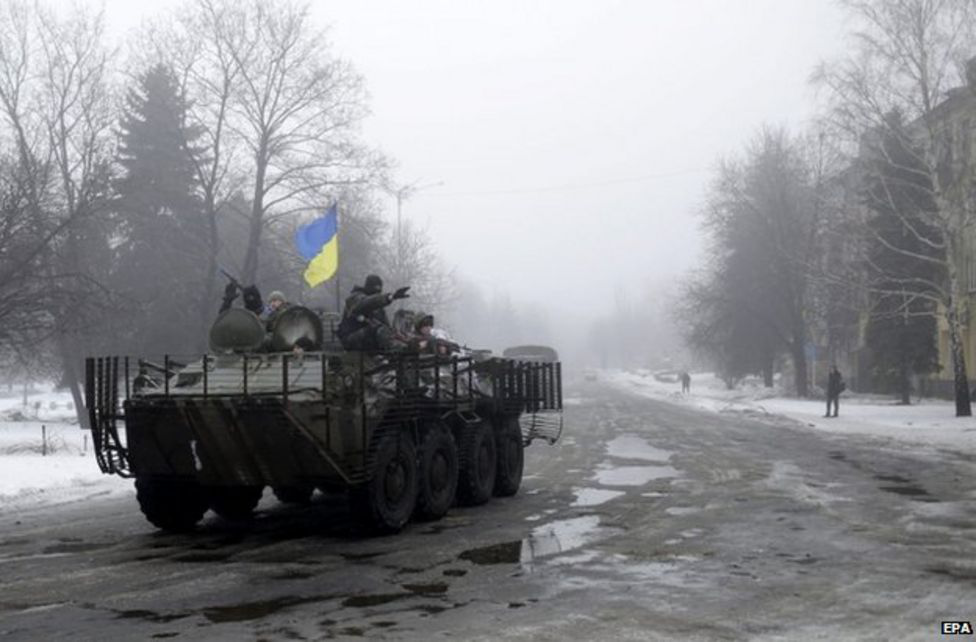

In [162]:
from PIL import Image

# Load and display the image
# Load and display the image
image_path = '/Users/user/Desktop/backupThesis/Thesis_model/all_images/military/_80403227_025499461-1.jpg'
# image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/all_frames/frame_atres_noche_2023-02-02_sec_1165.jpg'
# image_path = '/Users/user/Downloads/WhatsApp Image 2024-06-13 at 15.35.23.jpeg'
# image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/labelled_images/frame_atres_noche_2022-12-03_sec_120.jpg'
# image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/labelled_images/frame_atres_noche_2022-12-03_sec_1181.jpg'
image = Image.open(image_path)
image
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# plt.show()

In [163]:
# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [164]:
# Set the model to evaluation mode
resnet50.eval()

# Move the image tensor to the same device as the model
image_tensor = image_tensor.to(device)

# Get the prediction
with torch.no_grad():
    output = resnet50(image_tensor)
    probability = torch.sigmoid(output).item()

# Convert the probability to a binary prediction
prediction = 1 if probability > 0.5 else 0

# Print the prediction
labels = {0: 'Not war', 1: 'War'}
print(f"Predicted class: '{labels[prediction]}' with probability of war being: {probability:.4f}")

Predicted class: 'War' with probability of war being: 0.9775


### Occlusion Sensitivity

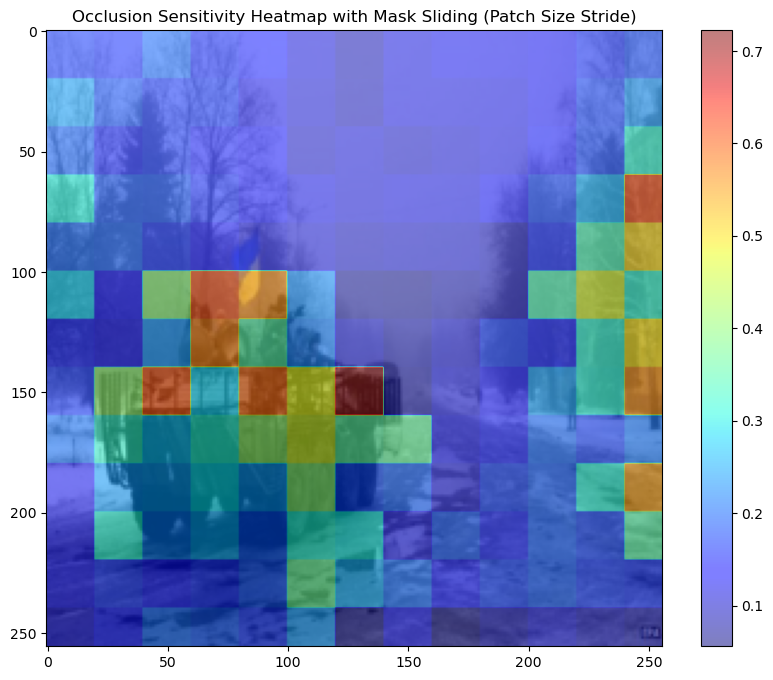

In [169]:
# Define the same transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Plot the transformed image
transformed_image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Remove batch dimension and convert to HWC
transformed_image = transformed_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
transformed_image = np.clip(transformed_image, 0, 1)  # Clip to valid range

# Perform occlusion sensitivity analysis
resnet50.eval()
image_tensor = image_tensor.to(device)
heatmap = occlusion_sensitivity_mask(resnet50, image_tensor, patch_size=5)

# Display the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(transformed_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with the original image
plt.colorbar()
plt.title('Occlusion Sensitivity Heatmap with Mask Sliding (Patch Size Stride)')
plt.show()

### TODO:

- data augmentation
- try Learning Rate Scheduling (to adjust dynamically learning rate while training)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, patience=3)

- regularization
- Advanced Optimizers: AdamW
